<a href="https://colab.research.google.com/github/JosephBEAUREDER/FINE_TUNING_GESTURE/blob/main/extract_ELAN_H5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

L'idée globale de ce colab est de :

1.   Lire les fichiers .eaf avec les annotations
2.   Manipuler ces annotations (pour faire des catégories plus aptes au Machine-Learning)
2.   Faire des stats à partir de ces annotations
3.   Retrouver le bon interval_ID pour chaque label

5.   Mettre les labels dans un fichier .h5



# Extraction et traitement des données des fichiers .eaf



```
input : .eaf files
output : to_pickle = [[START, END, FILE_NAME, LABEL_MVMT_JOSEPH, LABEL_MVMT_CATHERINE, LABEL_HANDSHAPE_JOSEPH, LABEL_HANDSHAPE_CATHERINE, IMAGESCHEMA, DURATION], [...]]

#   (Les valeurs de START et END sont en 15 frames par secondes par rapport au début de la vidéo youtube dont le label est issu)
```



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive

import os
# os.chdir('/content')
!pip install pympi-ling

import pympi
import glob
from collections import Counter
import csv
import math
import re
import json

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [ ]:
# fonction qui convertit les frames d'un framerate de 1000 à un framerate de 15

def frame1000_to_frame15(frames: int) -> int:
    return math.floor(frames * (15 / 1000))


# fonction qui prend un fichier.eaf en entrée et retourne un tableau à 9 colonnes

  ## input = eaf file

  ## output = [[START,
  #            END,
  #            FILE_NAME,
  #            LABEL_MVMT_JOSEPH,
  #            LABEL_MVMT_CATHERINE,
  #            LABEL_HANDSHAPE_JOSEPH,
  #            LABEL_HANDSHAPE_CATHERINE,
  #            IMAGESCHEMA,
  #            DURATION]
  #            ,
  #           [...]
  #            ]


def extract_eaf(eaf_file_name):

  eaf = pympi.Elan.Eaf(eaf_file_name)

  data = eaf.get_annotation_data_for_tier('default')


  ## on enlève le chemin et .eaf du nom du fichier
  string = str(eaf_file_name)
  match = re.search(r'(?<=/)[^/]+(?=\.eaf)', string)
  title_file = match.group()

  # on prépare des tableaux pour traiter les labels
  tab_labels = []
  tab_start_end = []
  to_pickle = []


  for ligne in eaf.get_annotation_data_for_tier('default'):

    ## we build the tab that will stock the start_time /  end_time of each label
    start_time = frame1000_to_frame15(ligne[0])
    end_time = frame1000_to_frame15(ligne[1])
    tab_start_end.append([start_time,end_time])

    ## On split l'annotation pour avoir un tableau de la forme --> [IS, DURATION, MOUVEMENT, HANDSHAPE]
    tab_labels.append(ligne[2].split(" "))


# On crée tous les tableaux pour stocker les LABELS
  # tab_IS = ["OBJECT", "CONTAINER", "OBJECT", ...]
  tab_IS = []

  # tab_duration = ["SHORT", "SHORT-HOLD", "MULTIPLE", ...]
  tab_duration = []

  # tab_mvmt = ["EMERGE", "DOWN",...]
  tab_mvmt = []
  tab_mvmt_jo = []

  # tab_handshape = ["PYRAMID-DOWN, "GRASP-UP",...]
  tab_handshape = []
  tab_handshape_jo = []

  for ligne in tab_labels:
      try:
          tab_IS.append(ligne[0])
          tab_duration.append(ligne[1])
          tab_mvmt_jo.append(ligne[2])
          tab_mvmt.append(ligne[2])
          tab_handshape_jo.append(ligne[3])
          tab_handshape.append(ligne[3])

      # si l'annotation n'est pas de la forme -->  [IS, DURATION, MOUVEMENT, HANDSHAPE]
      #                                            (si l'annotation dans ELAN n'est pas de la forme "a b c d", avec des espaces entre chaque terme)
      except IndexError:
          print(eaf_file_name)
          print("l'erreur se trouve à la ligne : "+ str(ligne) + "du fichier" + str(eaf_file_name) + "!")


  REPLACEMENTS_STROKE = [

      (r"^SHORT$","ONE_STROKE"),
      (r"^SHORT-HOLD$","ONE_STROKE_HOLD"),
      ("MULTIPLE", "MULTIPLE_STROKES")
       ]

  for i in range(len(tab_duration)):
    for old, new in REPLACEMENTS_STROKE:
        tab_duration[i] = re.sub(old, new, tab_duration[i])


  REPLACEMENTS_HANDS = [
      ("OBJECT","ONE_HAND"),
      ("CONTAINER","TWO_HANDS")
  ]

  for ligne in range(len(tab_IS)):
      for old, new in REPLACEMENTS_HANDS:
          tab_IS[ligne] = tab_IS[ligne].replace(old,new)


    ## algo pour merge les différents labels de handshape en plus grosses catégories (RELAX, WRENCH/RING, FIST/GRASP ,PUOH)
  REPLACEMENTS_HANDSHAPE = [

  ("WRENCH", "RING"),

  ("PYRAMID-DOWN", "FIST"),
  ("PYRAMID-INWARD","FIST"),
  ("GRASP-UP", "FIST"),
  ("GRASP-DOWN", "FIST"),
  ("GRASP-FRONT", "FIST"),
  ("GRASP-SIDE","FIST"),


  ("INDEX-DOWN","RELAX"),
  ("INDEX-UP", "RELAX"),

  ("MID-UP", "RELAX"),
  ("MID-GRASP","RELAX"),
  ("MID-OPEN", "RELAX"),
  ("GRASP-SMOOTH","RELAX"),
  ("INWARD", "RELAX"),
  ("FORWARD","RELAX"),
  ("DOWNWARD","RELAX"),
  ("LIMIT","RELAX"),

  ("COUNTING", "RELAX"),
  ("CONFRONT","RELAX"),

  ("PALM-FACE","RELAX"),
  ("STRAIGHT", "RELAX"),
  ("PALM-DOWN","RELAX"),


  ("MID-DOWN","PUOH"),
  ]

  for ligne in range(len(tab_handshape)):
      for old, new in REPLACEMENTS_HANDSHAPE:
          tab_handshape[ligne] = tab_handshape[ligne].replace(old,new)


  ## algo pour merge les différents labels de mouvements en plus grosses catégories ()
  REPLACEMENTS_MOVEMENT = [

  ("OKAY", "IN-OUT_LARGE"),
  (r'^OPEN$',"IN-OUT_LARGE"),
  (r'^QUESTION$', "IN-OUT_LARGE"),
  (r'^UP$',"OTHER"),
  ("AGREE","OTHER"),
  ("ANY","IN-OUT_LARGE"),
  ("TURN-OUT","IN-OUT_LARGE"),


  ("SHRINK", "WRIST_ROTATION"),
  ("EMERGE-IN","WRIST_ROTATION"),
  ("EXPAND","WRIST_ROTATION"),
  (r'^REVERSE$', "WRIST_ROTATION"),
  ("REVERSE-UP","WRIST_ROTATION"),
  ("ROUND-IN", "WRIST_ROTATION"),
  ("TABLE","WRIST_ROTATION"),
  ("ROUND","WRIST_ROTATION"),
  (r"^EMERGE$","WRIST_ROTATION"),
  # this one is to be checked
  ("INOUT","WRIST_ROTATION"),
  ("QUESTION-SMALL","WRIST_ROTATION"),
  ("INSTANTIATE","WRIST_ROTATION"),
  (r'^BLOSSOM$',"WRIST_ROTATION"),

  (r'^UPDOWN$', "DOWNWARD"),
  (r'^DOWN$', "DOWNWARD"),
  ("INWARD","DOWNWARD"),
  (r'EMPHASE$',"DOWNWARD"),

  ("EMERGE-SIDE","SIDE"),
  (r"^BLOSSOM-SIDE$","SIDE"),
  ("RESPECT-SIDE","SIDE"),
  ("EMPHASE-SIDE","SIDE"),
  ("DOWN-SIDE","SIDE"),
  (r"^UP-SIDE$","SIDE"),

  ("MOULIN","ANTI-PHASE"),
  (r"^SORT$","ANTI-PHASE"),
  (r"DIFFERENCE","ANTI-PHASE"),

  ("CONFRONT", "OTHER"),
  (r'^FRONT$',"OTHER"),
  ("SORT-TWO-HANDS","OTHER"),
  ("NO-TWO-HANDS","OTHER"),
  ("COUNTING","OTHER"),
  (r'^NO$',"OTHER"),
  ("SORT-ONE-HAND", "OTHER"),
  ("THROW","OTHER"),
  ("TURN-IN","OTHER"),
  ("HOLD-UPDOWN","OTHER"),
  (r'^RESPECT$',"OTHER"),
  ]

  for i in range(len(tab_mvmt)):
    for old, new in REPLACEMENTS_MOVEMENT:
        tab_mvmt[i] = re.sub(old, new, tab_mvmt[i])



  # ici on .append tout dans la variable du 'to_pickle' du 'return'

    start_time =  tab_start_end[i][0]
    end_time = tab_start_end[i][1]
    movement_joseph = tab_mvmt_jo[i]
    movement_catherine = tab_mvmt[i]
    handshape_joseph = tab_handshape_jo[i]
    handshape_catherine = tab_handshape[i]
    IS = tab_IS[i]
    duration = tab_duration[i]

    to_pickle.append([start_time, end_time, title_file, movement_joseph, movement_catherine, handshape_joseph, handshape_catherine, IS, duration])


  return to_pickle


Maintenant qu'on a crée la fonction, on peut créer l'algo qui va lire tout le dossier avec les .eaf et stocker toute les valeurs nécessaires dans la variable 'to_pickle' qui est de la forme :


In [ ]:
folderpath = "EAF/ALL/"

files = [file for file in glob.glob(folderpath+"*.eaf")]
to_pickle = []
for elan_file_name in files:
  data = extract_eaf(elan_file_name)
  for i in range(len(data)):
    to_pickle.append(data[i])

# to_pickle = [[START, END, FILE_NAME, LABEL_MVMT_JOSEPH, LABEL_MVMT_CATHERINE, LABEL_HANDSHAPE_JOSEPH, LABEL_HANDSHAPE_CATHERINE, IMAGESCHEMA, DURATION], [...]]

#   (Les valeurs de START et END sont en 15 frames par secondes par rapport au début de la vidéo youtube dont le label est issu)

print(to_pickle[0])
print(len(to_pickle))

[4076, 4090, '2B9b9mUPJik', 'EMPHASE', 'DOWNWARD', 'GRASP', 'GRASP', 'ONE_HAND', 'MULTIPLE_STROKES']
1441


In [ ]:
# check if other labels than "ONE_HAND" or "TWO_HANDS"
for i in to_pickle:
  if i[4]== 'ANTI-PHASE' and i[7] == 'TWO_HANDS':
    print(i)

In [ ]:
sum = 0
for i in to_pickle:
  sum = sum + (i[1] - i[0])

print(sum/1441)

21.51145038167939


# Statistiques (optionnel)



 Ici les fonctions pour faire les stats :




 - stat_nb_label(tab)
-     **input :**
    - tab = liste des labels (tab_nb_hands or tab_mouvement_catherine)
-  **output :**
    - MOUVEMENT / Nombre d'apparition
```
print(stat_nb_label(tab_nb_hands))
```

- avg_diff(tab, label)
 -

- histogram (tab, category of label)
  - **Input :**
    - tab = to_pickle
    - category of label = "nb_of_hands" or "movement_catherine"
  - **Output** = one histogram par label
    - X axis = duration (in 15 frames/seconde)
    - Y axis = Nb of labels
```
print(histogram(to_pickle, "nb_of_hands"))
```

## les fonctions :

In [ ]:
# on construit un tableau pour chaque label

tab_strokes = [i[8] for i in to_pickle]
tab_nb_hands = [i[7] for i in to_pickle]
tab_mouvement_joseph = [i[3] for i in to_pickle]
tab_mouvement_catherine = [i[4] for i in to_pickle]
tab_handshape_joseph = [i[5] for i in to_pickle]
tab_handshape_catherine = [i[6] for i in to_pickle]

print(tab_mouvement_joseph[0])
print(len(tab_mouvement_joseph))

EMPHASE
1441


In [ ]:
## fonction pour compter le nombre de chaque label

def stat_nb_label(tab):

    ## input : un des tableaux de la cellule au dessus
    ## output : MOUVEMENT / Nombre d'apparition
    #           Nombre de labels différents


  counter_tab = Counter(tab)
  nb = 0
  for key, value in counter_tab.items():
    print(key, value)
    nb += 1
    print("on est sur du "+str(int(value/len(tab)*100))+"%")
  print("Il y a "+str(nb)+ " labels différents")


stat_nb_label(tab_mouvement_catherine)

DOWNWARD 483
on est sur du 33%
WRIST_ROTATION 483
on est sur du 33%
OTHER 150
on est sur du 10%
SIDE 146
on est sur du 10%
ANTI-PHASE 69
on est sur du 4%
IN-OUT_LARGE 110
on est sur du 7%
Il y a 6 labels différents


In [ ]:
def avg_diff(tab, label):

    ## input : tab (list) = le tableau a 7 colonnes 'to_pickle'
    ##         label (string) = la catégorie dont on veut avoir les stats, à choisir entre :  "movement_joseph"  /  "movement_catherine"  /  "handshape_joseph"  /  "handshape_catherine"

    ## output : dic de la forme : {'LABEL': average length (in millisecond), ...}


  result = {}
  for start, end, title, mvmt_jo, mvmt_cath, handshape_jo, handshape_cath in tab:
      string = None
      if label == "movement_joseph":
          string = mvmt_jo
      elif label == "movement_catherine":
          string = mvmt_cath
      elif label == "handshape_joseph":
          string = handshape_jo
      elif label == "handshape_catherine":
            string = handshape_cath

      else:
        print("2nd arguement isn't valid, try : movement_joseph  or  movement_catherine or  handshape_joseph  or  handshape_catherine")
        break

      if string not in result:
          result[string] = []
      result[string].append(end-start)
  for key in result:
      result[key] = sum(result[key])/len(result[key])
  return result



Maintenant on crée la fonction pour print les histogrammes :

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def histogram(tab, label):

  ## input : tab(list) = to_pickle
  ##         label (string) = la catégorie dont on veut avoir les stats, à choisir entre :  "movement_joseph"  /  "movement_catherine"  /  "handshape_joseph"  /  "handshape_catherine"

  ## output : histogram de la répartition du temps de chacun des labels

  if label == "movement_joseph":
      nb = 3
  elif label == "nb_of_hands":
      nb = 7
  elif label == "movement_catherine":
      nb = 4
  elif label == "handshape_joseph":
      nb = 5
  elif label == "handshape_catherine":
        nb = 6

  labels = [i[nb] for i in tab]
  values = [row[1] - row[0] for row in tab]

  unique_labels = np.unique(labels)

  for label in unique_labels:
      label_values = [values[i] for i in range(len(labels)) if labels[i] == label]
      hist, bin_edges = np.histogram(label_values, bins=6)
      plt.figure(figsize=(4, 2))
      plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges))
      plt.title(f'Histogram for label: {label}')
      plt.xlabel('Timestep (Framerate = 15)')
      plt.ylabel('Number of labels')
      plt.tight_layout()
      plt.show()

In [ ]:
# tab_mouvement_catherine_bis = [(i[1] - i[0],i[4]) for i in to_pickle]
# tab_handshape_catherine_bis = [(i[1] - i[0],i[6]) for i in to_pickle]
# tab_IS = [(i[1] - i[0],i[7]) for i in to_pickle]

# total = 0
# for i in tab_IS:
#   total =  total + i[0]

# mean_IS = total - len(tab_IS)

# print("mean IS is " + str(mean_IS))


# total = 0

# for i in tab_mouvement_catherine_bis:
#   total =  total + i[0]

# mean_mvmt = total/len(tab_IS)


# print("mean mvmt is " + str(mean_mvmt))
# print("mean_m is" + str(mean_m))

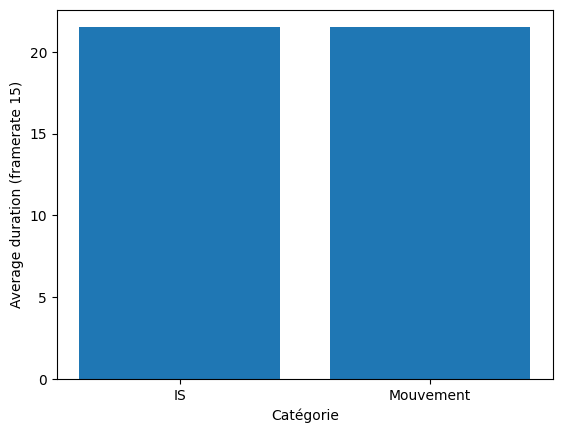

In [ ]:
labels = ['IS', 'Mouvement']
values = [21.49, 21.49]

# Plotting histogram
plt.bar(labels, values)

# Adding labels to the axes
plt.xlabel('Catégorie')
plt.ylabel('Average duration (framerate 15)')

# Display the plot
plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# tab = tab_mouvement_catherine_bis

# # Extract labels and values
# labels = list(set(entry[1] for entry in tab))
# values = {label: [] for label in labels}
# for entry in tab:
#     values[entry[1]].append(entry[0])

# # Calculate average values
# avg_values = {label: np.mean(values[label]) for label in labels}

# # Plotting histogram
# plt.bar(avg_values.keys(), avg_values.values())

# # Adding labels to the axes
# plt.xlabel('Labels')
# plt.ylabel('Average duration (framerate 15)')
# plt.title(f'Histogram for Mouvement 2')

# # Display the plot
# plt.show()


## les prints

In [ ]:
tab_strokes = [i[8] for i in to_pickle]
tab_nb_hands = [i[7] for i in to_pickle]
tab_mouvement_joseph = [i[3] for i in to_pickle]
tab_mouvement_catherine = [i[4] for i in to_pickle]
tab_handshape_joseph = [i[5] for i in to_pickle]
tab_handshape_catherine = [i[6] for i in to_pickle]

In [ ]:
print(stat_nb_label(tab_mouvement_catherine))

DOWNWARD 483
on est sur du 33%
WRIST_ROTATION 483
on est sur du 33%
OTHER 150
on est sur du 10%
SIDE 146
on est sur du 10%
ANTI-PHASE 69
on est sur du 4%
IN-OUT_LARGE 110
on est sur du 7%
Il y a 6 labels différents
None


In [ ]:
print(histogram(to_pickle, "nb_of_hands"))

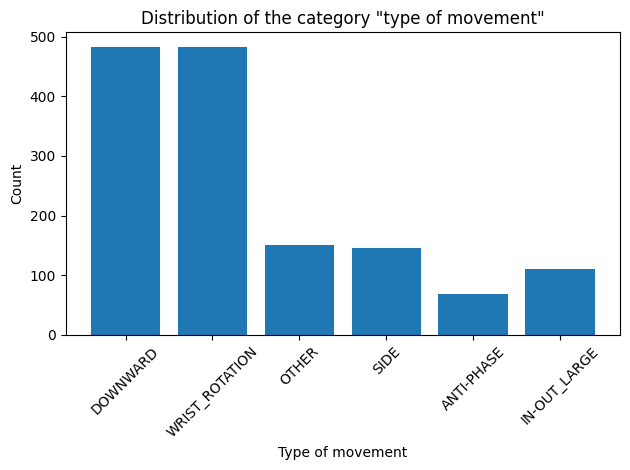

In [ ]:
import matplotlib.pyplot as plt

# Given data
labels = ['DOWNWARD', 'WRIST_ROTATION', 'OTHER', 'SIDE', 'ANTI-PHASE', 'IN-OUT_LARGE']
counts = [483, 483, 150, 146, 69, 110]

# Create the histogram
plt.bar(labels, counts)

# Add labels and title
plt.xlabel('Type of movement')
plt.ylabel('Count')
plt.title('Distribution of the category "type of movement"')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the histogram
plt.tight_layout()
plt.show()


# CSV

Maintenant que l'on possède le tableau avec tous les [start_time, end_time, label...], il faut savoir dans quel "interval_id" (sous-segment de la vidéo youtube) se situe chaque label, car c'est de cette manière que sont découpés les fichiers .h5 du PATS Dataset.

Pour cela :
*   On va lire le fichier "cmu__intervals_df.csv"
*   On va formater les timecodes/dates
*   On va convertir les timecodes en frames (framerate = 15)
*   On va checker, en fonction de la vidéo, si le label se trouve dans chaque "interval_id", si c'est le cas, on ajoute l'interval_id à notre tableau dans un tableau final qui s'appellera "to_pickle_final"

On lit le CSV :

In [ ]:
CSV = []

with open("CSV/cmu_intervals_df.csv", mode='r') as file:
    reader = csv.reader(file)
    for row in reader:
        CSV.append(row)

print((CSV[0]))
print((CSV[1]))

['dataset', 'delta_time', 'end_time', 'interval_id', 'speaker', 'start_time', 'video_fn', 'video_link']
['train', '25.825826', '2019-06-07 00:13:07.420754', '120149', 'almaram', '2019-06-07 00:12:41.594928', 'Lessons_in_Fiqh_02-_How_to_do_wudu-iUGLu4BYH7s.mkv', 'http://www.youtube.com/watch?v=iUGLu4BYH7s']


In [ ]:
CSV[1][4]

'almaram'

In [ ]:
summ = 0
for i in range(1,len(CSV)):
  if CSV[i][4] == 'lec_hist':
    summ = summ + float(CSV[i][1])

print(summ)

10505.933333333327


Ensuite on crée un algo :

* pour formater toutes les date sous le même format :
2019-06-07 00:13:07.420754

*   Et garder que les colonnes pertinentes

Dans un nouveau tableau qui va s'appeler : newCSV = [[start, end, interval_id, video_fn],[...]]


In [ ]:
for i in range(len(CSV)):

  ## le cas où le time s'affiche ainsi : 2019-09-26 00:02:54
  if len(CSV[i][2]) == 19:
    CSV[i][2]= CSV[i][2] + ".000000000"
  if len(CSV[i][5]) == 19:
    CSV[i][5]= CSV[i][5] + ".000000000"


  ## le cas où le time s'affiche ainsi : 2019-09-26 00:00:22.500000
  if len(CSV[i][2]) == 26:
    CSV[i][2]= CSV[i][2] + "000"
  if len(CSV[i][5]) == 26:
    CSV[i][5]= CSV[i][5] + "000"


  ## ensuite on cut les dates pour passer de ça : 2019-06-07 00:13:07.420754
  ##                                            à ça : 00:13:07.420

newCSV = []
for a in range(1,len(CSV)):
    newCSV.append( [CSV[a][5][11:23],CSV[a][2][11:23],CSV[a][3],CSV[a][6]])


## newCSV = [start, end, interval_id, video_fn]
print((newCSV[0]))


['00:12:41.594', '00:13:07.420', '120149', 'Lessons_in_Fiqh_02-_How_to_do_wudu-iUGLu4BYH7s.mkv']


In [ ]:
## function pour convertir les timecodes en frames

def time_to_frames(time_string, frame_rate):
    time_parts = time_string.split(':')
    hours, minutes = map(int, time_parts[:2])
    seconds = float(time_parts[2])
    total_seconds = hours * 3600 + minutes * 60 + seconds
    total_frames = int(total_seconds * frame_rate)
    return total_frames

In [ ]:
## algo pour changer les timecodes en frames (framerate = 15) sur le CSV

## input : newCSV --> [START, END, Interval ID, video_title]
## output : new_CSV_frames --> [START, END, Interval ID, video_title]

new_CSV_frames = []
for a in range(len(newCSV)):
    x = time_to_frames(newCSV[a][0],15)
    y = time_to_frames(newCSV[a][1],15)
    new_CSV_frames.append([x,y, newCSV[a][2],newCSV[a][3]])

print(new_CSV_frames[0])

[11423, 11811, '120149', 'Lessons_in_Fiqh_02-_How_to_do_wudu-iUGLu4BYH7s.mkv']


# Get interval_ID

Maintenant on crée l'algo qui va checker dans quel interval_ID le label se trouve en fonction :
- du titre de la vidéo --> enregistré dans to_pickle[i][2]
- du timestep du label --> début = to_pickle[0]    / fin = to_pickle[1]


    - to_pickle_final[i][0] = start of label
    - to_pickle_final[i][1] = end of label
    - to_pickle_final[i][3] = label of movement
    - to_pickle_final[i][6] = label of nb_of_hand
    - to_pickle_final[i][8] = interval_ID


```
to_pickle_final = [[START ,END, LABEL_MVMT_JOSEPH, LABEL_MVMT_CATHERINE,LABEL_HANDSHAPE_JOSEPH, LABEL_HANDSHAPE_CATHERINE, nb_of_hands, DURATION,INTERVAL_ID] , [...]]
```


In [ ]:
# l'algo qui, en fonction du titre de la vidéo, va checker dans quel interval_ID le label se trouve,
# et va tout ajouter dans le tableau "to_pickle_final" qui ressemble à ça pour chaque label :

  # to_pickle_final =

  #           [[START ,
  #            END,
  #            LABEL_MVMT_JOSEPH,
  #            LABEL_MVMT_CATHERINE,
  #            LABEL_HANDSHAPE_JOSEPH,
  #            LABEL_HANDSHAPE_CATHERINE,
  #            IMAGESCHEMA,
  #            DURATION,
  #            INTERVAL_ID]
  #            ,
  #           [...]
  #            ]

to_pickle_final = []

for i in range(len(to_pickle)):
  pb = False
  for j in range(len(new_CSV_frames)):
    if to_pickle[i][2]==new_CSV_frames[j][3]:

      lower_bound = new_CSV_frames[j][0]
      upper_bound = new_CSV_frames[j][1]

      if lower_bound <= to_pickle[i][0] <= upper_bound and lower_bound <= to_pickle[i][1] <= upper_bound:
        to_pickle_final.append([to_pickle[i][0],to_pickle[i][1],to_pickle[i][3],to_pickle[i][4],to_pickle[i][5],to_pickle[i][6],to_pickle[i][7],to_pickle[i][8],new_CSV_frames[j][2]])
      # print("ligne "+ str(i) + " we good1")
        pb = True
  if pb == False:
        print("on a un pb ligne :" + str(i))
        print(to_pickle[i])


In [ ]:
# 2. on formate les valeurs de début/fin de 'to_pickle_final' en fonction de la scène (et non plus en fonction de la vidéo entière)

for i in to_pickle_final:
  for j in new_CSV_frames:
    if i[8]==j[2]:
      i[0]= i[0]-j[0]
      i[1]= i[1]-j[0]

In [ ]:
print(to_pickle_final[0])

[0, 14, 'EMPHASE', 'DOWNWARD', 'GRASP', 'GRASP', 'ONE_HAND', 'MULTIPLE_STROKES', 'cmu0000028893']


# On crée la base de données


Avec en output un tableau de type :



```
POSE_of_label_X1 = toutes les séquences de POSE data correspondant à la durée du label X1

label = le label associé

end_tab = [
           [[POSE_of_label_X1], [pose_of_label_X2], ...],
            [X1, X2, ...]
                          ]
```


In [ ]:
!pip install transformers --quiet
!pip install tqdm --quiet
!pip install nltk --quiet
!pip install h5py --quiet
!pip install pandas joblib --quiet
from data import HDF5
from data import Data
from tqdm import tqdm
import torch
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.8 MB/s eta 0:00:00


In [ ]:
def remove_fingers(pose):
  # reshape pose
  pose = np.reshape(pose, (pose.shape[0], 2, -1))
  pose = torch.from_numpy(pose)

  # remove fingers
  pose_ = pose[:, :, 1:11]
  pose = torch.cat((pose_, pose[:, :, 31:32]), dim=2)
  pose = pose.reshape(pose.shape[0], 2, 11)


# Uncomment these ligns if you want to keep only the wrists
  # # on garde que les wrists
  # indices = [1, 4]

  # # Keep only the desired items using array indexing
  # pose = pose[:, :, indices]

  # pose = pose.reshape(len(pose),4)




  # reshape and turn it into numpy array
  pose = pose.reshape(len(pose), 22)
  pose = pose.numpy()
  return pose

In [ ]:
data, h5 = HDF5.load('pats/data/processed/ALL/cmu0000030782.h5', key='pose/normalize')
pose = data[()]

# on enlève les données POSE des doigts
pose = remove_fingers(pose)
print(pose.shape)

print(pose[0])

(101, 22)
[-166.78261815 -233.12350946 -162.53611136  171.0433127   239.46434843
  111.15457974  -23.49275382  -44.86170856    8.50610997  140.28860664
 -183.85377188   -8.518115    192.43191204  220.20391363    4.25196362
  228.80606385  213.86416603 -151.83417213 -183.87014238 -183.86905101
  217.54425364  217.74288233]


## Algo pour créer le tableau end_tab avec toutes les features/labels



```
end_tab = [ [[POSE_X1], [POSE_X2], ..., [POSE_XN]],
            [label_hand_X1, label_hand_X2, ..., label_hand_XN],
            [label_movement_X1, label_movement_X2, ..., label_movement_XN]
          ]

POSE = toutes les frames de POSE associées à la durée du label
```



In [ ]:
end_tab = []

list_pose = []
list_label_movement = []
list_label_nb_of_hands = []

cpt = 0

for i in range(len(to_pickle_final)):

  intervals_ID = to_pickle_final[i][8]
  data, h5 = HDF5.load('pats/data/processed/ALL/'+intervals_ID+'.h5', key='pose/normalize')
  pose = data[()]

  # on enlève les données POSE des doigts
  pose = remove_fingers(pose)

  # on instantie le tableau qui va recueillir l'ensemble des frames de POSE pour 1 label
  pose_of_one_label = []

  start_label = to_pickle_final[i][0]
  end_label = to_pickle_final[i][1]

  label_of_movement = to_pickle_final[i][3]
  nb_of_hands = to_pickle_final[i][6]

# ici on définit la longueur maximale de la séquence, ici 30 frames (= 2 secondes)
  max_len_sequence = 64
  cpt = 0

  # on met dans un tableau temporaire chaque frame de data POSE en fonction du début/fin du geste
  for j in range(start_label, end_label):
    if cpt <= max_len_sequence:

      pose_of_one_label.append(pose[j])
      cpt += 1


  # on crée trois tableaux pour séparer les données dans le tableau final
  list_pose.append(pose_of_one_label)
  list_label_movement.append(label_of_movement)
  list_label_nb_of_hands.append(nb_of_hands)

end_tab.append(list_pose)
end_tab.append(list_label_movement)
end_tab.append(list_label_nb_of_hands)


In [ ]:
print((end_tab[0][0][0]))

[-166.57451473 -246.37125035 -222.68566001  154.60552477  324.50707178
  443.49270899  -32.27984551  -57.81976197   -3.48054759  463.63183557
 -239.48908112   11.91348159  237.9175007    98.54381662  -33.96677924
   57.81282342  139.31297182  -96.84040385 -130.74473618 -130.91906712
  155.58212497   72.77319354]


In [ ]:
# on stocke toutes les données (features+labels) dans un pickle : data_ALL.pickle

import pickle

name_of_file = 'data_ALL.pickle'

DATA_PATH = "/content/drive/MyDrive/pickle"
outfile = open(DATA_PATH+'/'+name_of_file,'wb')
pickle.dump(end_tab, outfile)
outfile.close()

NameError: ignored

# Fonction pour plot les gestes


In [ ]:
import numpy as np
import sys
import math
import matplotlib.pyplot as plt
import torch
import random
import imageio
import os
import moviepy.editor as mp
from scipy.interpolate import UnivariateSpline
from scipy.signal import medfilt2d, medfilt
import seaborn as sns
from os import path
from data import HDF5


import sys
from sklearn.preprocessing import OneHotEncoder
import os
# sys.path.insert(0, '/u/anasynth/fares/StyleEmbedding/11joints/')

import pandas as pd
from data import HDF5
import torch
import numpy as np
import pickle
from nltk.tokenize import sent_tokenize
import nltk.data
import os.path



def generate_pose_animation(N, pose_gestures, fingers, with_neck):
    """
    This functions renders 2D pose skeletons animation.
    Inputs:

    N: number of timesteps
    pose_gestures: array of poses - shape ()
    fingers: set fingers to True to plot fingers too; False otherwise.
    with_neck: set it to True to plot the neck; False otherwise

    Output: saves the 2D pose animation (.gif/.mp4)

    """

    gestures = []
    count=0
    bone_list = get_bone_list(fingers)
    gestures = pose_gestures
    print(gestures.shape)
    # set bones colors
    colors = []
    for bone in bone_list:
        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)
        colors.append(color)
    filenames = []

    for i in range(N):
        print('plotting timestep ', i)
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        skeleton_raw = gestures[i]

        x1 = (skeleton_raw[0, :])
        y1 = (-skeleton_raw[1, :])

        neckX = ((float(x1[3]) + float(x1[0])) / float(2.0))
        neckY = ((float(y1[3]) + float(y1[0])) / float(2.0))

        x1 = np.append(x1, neckX)
        y1 = np.append(y1, neckY)


        for index, bone in enumerate(bone_list):
            joint1_id = bone[0]
            joint2_id = bone[1]
            color_skeleton = colors[index]
            if (joint1_id == -1 and joint2_id ==6) or (joint1_id == 6 and joint2_id ==7) or (joint1_id == 6 and joint2_id ==8):
                ax1.plot([x1[joint1_id], x1[joint2_id]], [y1[joint1_id], y1[joint2_id]],  c='k', alpha=0.5, linewidth=5)
            else:
                ax1.plot([x1[joint1_id], x1[joint2_id]], [y1[joint1_id], y1[joint2_id]],  c=color_skeleton, linewidth=5)

        # scatter joints
        ax1.scatter(x1, y1, s=10, c='k', alpha=0.5, zorder=10)

        # color left and right wrists
        left_wrist_x = x1[5]
        left_wrist_y = y1[5]
        right_wrist_x = x1[2]
        right_wrist_y = y1[2]
        ax1.scatter(left_wrist_x, left_wrist_y, s=40, c='r', alpha=1, zorder=10)
        ax1.scatter(right_wrist_x, right_wrist_y, s=40, c='b', alpha=1, zorder=10)

        plt.axis('off')
        plt.savefig('leo_paul_'+'timestep_'+str(i)+'.png')
        plt.close()
        filenames.append('leo_paul_'+'timestep_'+str(i)+'.png')


    # build gif
    fps=15
    with imageio.get_writer('leo_paul.gif', mode='I', fps=fps, loop=1) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
    writer.close()

    # Remove files
    for filename in set(filenames):
        os.remove(filename)

    # convert to .mp4
    clip = mp.VideoFileClip('leo_paul.gif')
    clip.write_videofile('leo_paul.mp4')

    # remove gif file
    os.remove('leo_paul.gif')



# On crée le modèle de classification en LSTM

## On importe les données (features/label)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive

import pickle

# Specify the path to your pickle file
pickle_file_path = '/content/drive/MyDrive/pickle/data_ALL.pickle'

# Open the pickle file in read mode
with open(pickle_file_path, 'rb') as file:
    # Load the contents of the pickle file
    end_tab = pickle.load(file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


EOFError: ignored

In [ ]:
print(len(end_tab[0]))

1441


## On normalise les data :

In [ ]:
# avant la normalisation
print((end_tab[0][0][0]))

[-166.57451473 -246.37125035 -222.68566001  154.60552477  324.50707178
  443.49270899  -32.27984551  -57.81976197   -3.48054759  463.63183557
 -239.48908112   11.91348159  237.9175007    98.54381662  -33.96677924
   57.81282342  139.31297182  -96.84040385 -130.74473618 -130.91906712
  155.58212497   72.77319354]


In [ ]:
from sklearn import preprocessing
import numpy as np

# Pour cela on est obligé de donner en input de la fonction .normalize une seule frame d'une séquence

normalized_pose = []

# pour chaque label
for sequence in end_tab[0]:

  # on instancie le tableau qui va recueillir les toutes les donneés POSE normalisée pour 1 label
  normalized_pose_1_label = []

  # pour chaque séquence de ce label
  for frame in sequence:

      x_array = frame

      normalized_arr = preprocessing.normalize([x_array])

      normalized_pose_1_label.append(normalized_arr)

  normalized_pose.append(normalized_pose_1_label)

In [ ]:
# après la normalisation
print(normalized_pose[0][0])

[[-0.17518536 -0.25910708 -0.23419709  0.16259765  0.34128202  0.46641846
  -0.03394851 -0.06080868 -0.00366047  0.48759865 -0.25186914  0.01252933
   0.25021632  0.1036379  -0.03572265  0.06080138  0.14651457 -0.10184644
  -0.13750341 -0.13768675  0.16362473  0.0765351 ]]


## On padd les données pour que toutes les séquences soient égales à 64

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Convert to NumPy array
normalized_pose = np.array(normalized_pose, dtype=object)

# Pad the second dimension to length 64
features = pad_sequences(normalized_pose, maxlen=64, dtype='float32', padding='post', value=np.zeros(22))

features = np.squeeze(features)

print(features.shape)

(1441, 64, 22)


## Et on crée le mask

In [ ]:
# Create a mask for the padded sequences
mask = np.not_equal(features, 0).astype('float32')

print(mask.shape)

(1441, 64, 22)


## On encode les labels




In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# on récupère le tableau
labels_nb_hands = np.array(end_tab[2])

# Convert labels to integers
label_encoder = LabelEncoder()
labels_nb_hands = label_encoder.fit_transform(labels_nb_hands)

# Check the shape of the encoded labels
print(labels_nb_hands.shape)
for i in range(5):
  print(labels_nb_hands[i])

(1441,)
0
1
1
0
1


# On crée l'autoencoder (en cours)

In [ ]:
# ici l'encoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM

encoder = Sequential()
encoder.add(LSTM(256, input_shape=(64, 22)))


In [ ]:
# ici le decoder

from tensorflow.keras.layers import RepeatVector

# Add RepeatVector layer to match the encoder output shape
encoder_output_shape = encoder.output_shape[1:]  # Extract the shape of the encoder output
decoder = Sequential()
decoder.add(RepeatVector(encoder_output_shape[0]))

# Add LSTM layers to the decoder
decoder.add(LSTM(256, return_sequences=True))  # Adjust the number of LSTM layers as needed
# Add more LSTM layers if needed

# Add a Dense layer for output reconstruction
decoder.add(Dense(input_dim, activation='sigmoid'))

# On reprend le modèle

##  On shuffle les data :

In [ ]:
# import random

# # on utilise la fonction zip pour pairer les labels/features
# shuffled_data = list(zip(features, labels_nb_hands))

# # puis on shuffle
# random.shuffle(shuffled_data)

# # puis on unzip
# features, labels_nb_hands = zip(*shuffled_data)

##  On divise les données en train/test :

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels_nb_hands, test_size=0.10, random_state=42)

# X_train, features, y_train, labels_nb_hands = train_test_split(X_train, y_train, test_size=0.1765, random_state=42)


# Convert to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

# Create mask arrays
mask_train = np.sum(X_train != 0, axis=-1, keepdims=True).astype('float32')
mask_test = np.sum(X_test != 0, axis=-1, keepdims=True).astype('float32')

y_train = np.array(y_train)
y_test = np.array(y_test)

y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))

In [ ]:
X_train.shape

(1296, 64, 22)

## On définit l'architecture du modèle LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.layers import Bidirectional
import tensorflow as tf

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


In [ ]:
# # Clear TensorFlow session
# tf.keras.backend.clear_session()

max_seq_length = 64
nb_features = len(end_tab[0][0][0])

model = Sequential()

#

# model.add(tf.keras.layers.Masking(mask_value=0., input_shape=(64, nb_features)))
model.add(tf.keras.layers.Masking(mask_value=0., input_shape=(64, nb_features)))


model.add(LSTM(units=128, input_shape=(max_seq_length, nb_features), return_sequences=True))

model.add(LSTM(units=128, input_shape=(max_seq_length, nb_features), return_sequences=True))

model.add(LSTM(units=128, input_shape=(max_seq_length, nb_features), return_sequences=True))




# model.add(LSTM(units=64, input_shape=(max_seq_length, nb_features), return_sequences=False))

# model.add(LSTM(units=150, input_shape=(max_seq_length, nb_features), return_sequences=True))

# model.add(LSTM(units=150, input_shape=(max_seq_length, nb_features), return_sequences=True))


# Add a fully connected layer for output
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()




# Train your model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300, batch_size=16)
#, sample_weight=mask_train


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_3 (Masking)         (None, 64, 22)            0         
                                                                 
 lstm_27 (LSTM)              (None, 64, 128)           77312     
                                                                 
 lstm_28 (LSTM)              (None, 64, 128)           131584    
                                                                 
 lstm_29 (LSTM)              (None, 64, 128)           131584    
                                                                 
 dense_9 (Dense)             (None, 64, 1)             129       
                                                                 
Total params: 340,609
Trainable params: 340,609
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300


ValueError: ignored

In [ ]:
# Save the trained model

# model.save("good_model_hands.h5")

model.save("good_model_hands.h5")

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model("my_model.h5")

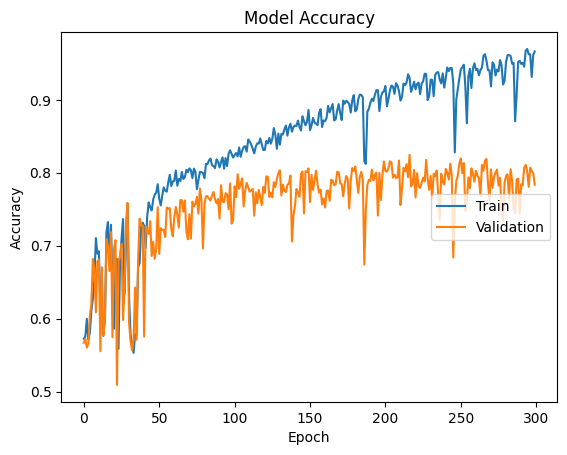

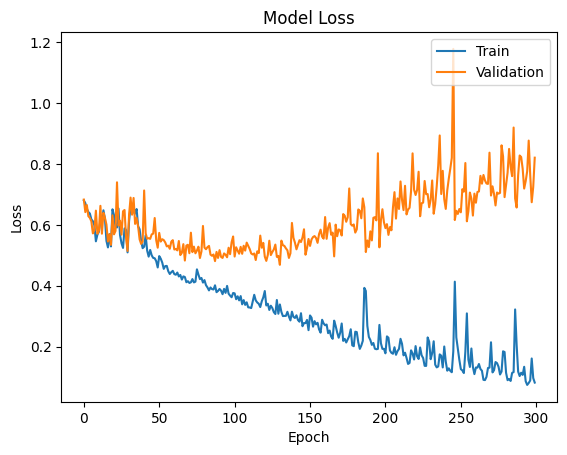

In [ ]:
import matplotlib.pyplot as plt

# Get the training history
history = model.history

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
predictions = model.predict(features_val_reshaped)

7/7 [==============================] - 5s 371ms/step


7/7 [==============================] - 2s 206ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


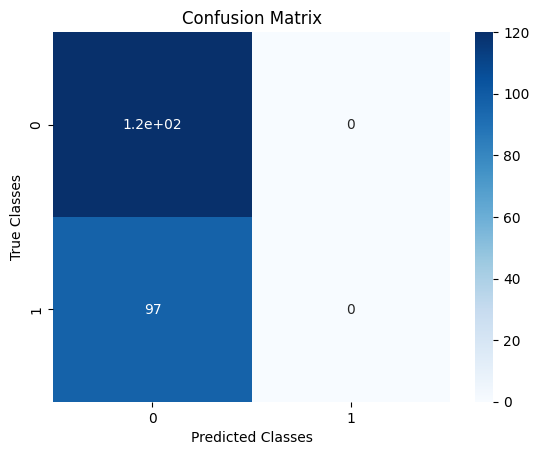

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Get predictions for the validation data
predictions = model.predict(features_val_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# Inverse transform the label encoding
true_classes = label_encoder.inverse_transform(labels_nb_hands_val)
predicted_classes = label_encoder.inverse_transform(predicted_classes)

# Create confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
print(type(features_train))
print(type(labels_nb_hands_train))
print(type(features_val))
print(type(labels_nb_hands_val))

<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.ndarray'>
<class 'list'>


In [ ]:
import pickle

DATA_PATH = "/content/drive/MyDrive/pickle"
outfile = open(DATA_PATH+'/annotation1.pickle','wb')
pickle.dump(end_tab, outfile)
outfile.close()

# - Autre projet - Création des fichiers .h5 (avec seulement les timestep annotés en fonction du label)
Il reste encore plusieurs steps pour préparer correctement la création du fichier .h5




## Etapes de préparation

1. On rajoute les 'interval_ID' qui font partie des vidéos traitées mais qui n'ont pas reçu de labels

2. On formate les valeurs de début/fin des labels 'to_pickle_final' en fonction de la scène (= interval_ID) et non plus en fonction de la vidéo entière

3. On crée un array (label_par_ID) qui met dans un même sous-array les labels qui possèdent le même 'interval_ID' (qui sont dans la même scène) car tous ces labels iront dans le même fichier .h5

4. 1. optionnel : on crée un dictionnaire pour mapper les 'intervals_ID' à leur durée, d'après les fichiers originaux du PATS dataset
  2. optionnel : on rajoute les key/value pour les speakers qui ne sont pas dans le dataset
  3. nécessaire : on charge le dictionnaire (dict_ID_length.json) dans la variable "dict_ID_length"

```
key = 'interval_ID'
value = length
dict_ID_length['cmu0000028533'] = 151
```




In [ ]:
# 1. algo pour rajouter les intervals_ID qui sont dans les vidéos traitées mais qui n'ont pas reçu d'annotation


# on crée deux listes
#     - pour stocker les noms de vidéo déjà traitées
#     - pour stocker les IDs déjà traités

video_names = set(i[2] for i in to_pickle)
video_names = list(video_names)

IDs = set(i[8] for i in to_pickle_final)
IDs = list(IDs)


# pour chaque vidéo
for i in video_names:
  # pour chaque interval_ID dans la vidéo
  for j in new_CSV_frames:
    if i == j[3]:
      # on regarde si l'interval a déjà été annoté
      if j[2] not in IDs:
        # si non, on l'ajoute au tableau to_pickle_final
        to_pickle_final.append([j[0],j[1], 'None', 'None', 'None', 'None','None','None',j[2]])

print(len(to_pickle_final))

2298


In [ ]:
# 3. algo pour mettre les labels qui possèdent la même ID (qui sont dans la même scène) dans les mêmes tableaux :

for i in range(len(to_pickle_final)):
  tab_same_ID = []
  tab_ID = []
  dict_lst = {}

  for tup in to_pickle_final:
    if tup[8] in dict_lst:
        dict_lst[tup[8]].append(tup)
    else:
        dict_lst[tup[8]] = [tup]

label_par_ID = list(dict_lst.values())

In [ ]:
# 4. ici un algo qui crée/charge un dictionnaire qui map les 'interval_ID' (key) à leur durée (value) d'après les fichiers .h5 originels de PATS



# partie nécessaire (si les speakers ont déjà été mappé) pour créer les fichiers .h5 avec une durée similaire à ceux du PATS dataset


filename = 'dict_ID_length.json'
# Open the JSON file and load its contents into a dictionary
with open(filename, 'r') as file:
    dict_ID_length = json.load(file)




## partie optionnelle si on veut rajouter des speakers


## on ajoute les librairies qui permettent de lire les fichiers.h5 du PATS dataset

# %cd /content/drive/MyDrive
# !pip install transformers
# from data import HDF5
# from data import Data
# from tqdm import tqdm

# !pip install tqdm
# !pip install nltk
# !pip install h5py
# !pip install pandas joblib

# # on lit le CSV
# for i in CSV:
#   # ici on met le speaker d'où l'on veut récupérer les 'interval_ID' (key) et la durée de la scène (value)
#   if i[4] == 'lec_hist':

#     # il faut avoir téléchargé tous les fichiers .h5 d'un même speaker dans un même dossier (à partir du dataset PATS)
#     data, h5 = HDF5.load('pats/data/processed/lec_hist/'+i[3]+'.h5', key='pose/normalize')

#     # on récupère la durée de la scène
#     len_scene = len(data[()])

#     # et on map la key ('interval_ID') à sa value (len_scene)
#     dict_ID_length[i[3]]= len_scene

# # et on sauvegarde
# with open(filename, 'w') as file:
#     json.dump(dict_ID_length, file, indent=4)


## Création des .h5 (---> no need anymore)

 **ATTENTION** à bien regarder le '**folderpath**'

In [ ]:
print(dict_ID_length['cmu0000029859'])

68


In [ ]:
import pandas as pd

# voici la fonction qui transforme les tableaux avec les labels qui ont la même interval_ID en h5

# input : [[LABEL],[LABEL],[LABEL]]

# output : h5

#           Movement_1 Movement_2           Handshape_1     Handshape_2      Nb_of_hands          Nb_of_strokes
# 170       None       None                 None            None             None                 None
# 171       EMERGE-IN  WRIST_ROTATION       PYRAMID-DOWN    FIST             ONE-HAND             ONE-STROKE-HOLD
# ...




folderpath = 'h5/ALL/'

# chaque item dans label_par_ID est un 'interval_ID' différent
for i in label_par_ID:

  # on récupère le nom de l'interval_ID
  ID = i[0][8]

  # on va chercher la durée du la scène d'après le fichier original (stocké dans le dictionnaire 'dict_ID_length'
  len_scene = dict_ID_length[ID]

  # on instantie le dataframe pour créer le h5
  df = pd.DataFrame(columns=['Movement_1', 'Movement_2', 'Handshape_1', 'Handshape_2', 'Nb_of_hands', 'Nb_of_strokes'], index=range(len_scene))


  # pour chaque label différent dans le même interval_ID
  for k in i:
    # on remplit les colonnes en fonction du début/fin de chaque label
    df.loc[k[0]:k[1]] = [k[2],k[3],k[4],k[5],k[6],k[7]]

  # hors des labels, les autres timestep sont considérés comme étant 'None'
  df = df.fillna('None')

  # on transfère tout dans un fichier .h5 qui a pour nom l'interval_ID (comme dans le PATS dataset)
  df['Movement_1'].to_hdf(folderpath + ID +'.h5', key='Movement_1', format='table', mode='w')
  df['Movement_2'].to_hdf(folderpath + ID +'.h5', key='Movement_2', format='table', mode='a')
  df['Handshape_1'].to_hdf(folderpath + ID +'.h5', key='Handshape_1', format='table', mode='a')
  df['Handshape_2'].to_hdf(folderpath + ID +'.h5', key='Handshape_2', format='table', mode='a')
  df['Nb_of_hands'].to_hdf(folderpath + ID +'.h5', key='Nb_of_hands', format='table', mode='a')
  df['Nb_of_strokes'].to_hdf(folderpath + ID +'.h5', key='Nb_of_strokes', format='table', mode='a')

In [ ]:
# petit algorithme pour vérifier que le nombre de fichier crée est bien égale à

folderpath = "h5/all/"

cpt = 0
for file in glob.glob(folderpath+"*.h5"):
  cpt = cpt +1
print("le nombre de fichier dans le dossier est de : " + str(cpt))

print("la taille de label_par_ID est de : " +  str(len(label_par_ID)))

le nombre de fichier dans le dossier est de : 1201
la taille de to_pickle_final est de : 1201


In [ ]:
## petit algo pour checker si les durée des h5 crées sont bien les mêmes que dans le dataset original
# (il faut donc tous les fichiers .h5 du PATS dataset disponible )

# for i in label_par_ID:
#   ID = i[0][8]
#   data, h5 = HDF5.load('pats/data/processed/almaram/'+ID+'.h5', key='pose/normalize')
#   len_a = len(data[()])

#   read_data = pd.read_hdf('h5/almaram/'+ID+'.h5', 'IS')
#   len_b = len(read_data)

#   if len_a != len_b:

L'algo pour créer les fichiers .h5 peut s'arrêter là.



Les algos qui suivent servent à extraire les 'pose' data des fichiers h5 et les ajouter à chaque label correspondant.